In [1]:
%load_ext jupyter_black
%matplotlib inline

In [2]:
import os

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"
os.environ["XLA_PYTHON_CLIENT_ALLOCATOR"] = "platform"

In [3]:
import numpyro

numpyro.set_platform("gpu")

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az

import jax.random as jr
import jax.numpy as jnp
import jax.tree_util as jtu

from jax import nn, config
from functools import partial

from pymdp.jax.agent import Agent as AIFAgent

from pybefit.inference import (
    run_svi,
    default_dict_numpyro_svi,
)

from pybefit.inference import NumpyroModel, NumpyroGuide
from pybefit.inference import (
    Normal,
    NormalPosterior,
    NormalGamma,
    NormalGammaPosterior,
    RegularisedHorseshoe,
    RegularisedHorseshoePosterior,
)
from pybefit.inference.numpyro.likelihoods import pymdp_likelihood as likelihood

from numpyro.infer import Predictive
import numpyro.distributions as dist

from pymdp.jax.task import PyMDPEnv

seed_key = jr.PRNGKey(101)
config.update("jax_default_matmul_precision", "float32")

2024-07-27 12:35:45.273347: W external/xla/xla/service/gpu/nvptx_compiler.cc:765] The NVIDIA driver's CUDA version is 12.4 which is older than the ptxas CUDA version (12.5.40). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [5]:
""" Defining state factors """

agency_names = [
    "sP_oP",
    "sP_oN",
    "sN_oP",
    "sN_oN",
]

self_action_names = ["self_buttonnotpress", "self_buttonpress"]
other_action_names = ["other_buttonnotpress", "other_buttonpress"]

""" Defining number of state factors and states """
num_states = [len(agency_names), len(self_action_names), len(other_action_names)]
num_factors = len(num_states)

""" Defining control state factors """
choice_agency_names = ["no_changes"]
choice_self_action_names = ["self_notpressbutton", "self_pressbutton"]
choice_other_action_names = ["equal_distribution"]

""" Defining number of control states """
num_controls = [
    len(choice_agency_names),
    len(choice_self_action_names),
    len(choice_other_action_names),
]

""" Defining observational modalities """
obs_outcome_names = ["outcome_absent", "outcome_present"]
obs_choice_self_names = ["self_buttonnotpress", "self_buttonpress"]
obs_choice_other_names = ["other_buttonnotpress", "other_buttonpress"]

""" Defining number of observational modalities and observations """
num_obs = [
    len(obs_outcome_names),
    len(obs_choice_self_names),
    len(obs_choice_other_names),
]
num_modalities = len(num_obs)

batch_size = 80  # number of subjects
num_blocks = 15
num_timesteps = 24

In [6]:
num_exp_conditions = 5


def make_agency_task(p_outcome_env=1.0, p_other_action_env=0.5):
    a1 = jnp.array([1 - p_outcome_env, p_outcome_env])
    a2 = 1 - a1
    a3 = jnp.array([0.5, 0.5])
    A1 = jnp.stack([a1, a2, a1, a2, a3], -1)
    A2 = jnp.stack([a1, a2, a2, a1, a3], -1)
    A3 = jnp.stack([a2, a1, a1, a2, a3], -1)
    A4 = jnp.stack([a2, a1, a2, a1, a3], -1)
    _A = jnp.stack([A4, A3, A2, A1], -1).reshape(2, 5, 2, 2)

    a = jnp.eye(2)
    A = [
        jnp.broadcast_to(_A, (batch_size,) + _A.shape),
        jnp.broadcast_to(a, (batch_size,) + a.shape),
        jnp.broadcast_to(a, (batch_size,) + a.shape),
    ]

    B2 = jnp.stack([jnp.array([[1, 1], [0, 0]]), jnp.array([[0, 0], [1, 1]])], -1)
    B = [
        jnp.broadcast_to(
            jnp.eye(num_exp_conditions)[..., None],
            (batch_size, num_exp_conditions, num_exp_conditions, 1),
        ),
        jnp.broadcast_to(B2, (batch_size, 2, 2, 2)),
        jnp.broadcast_to(
            jnp.ones((num_states[-1], num_states[-1], 1)) / num_states[-1],
            (batch_size, num_states[-1], num_states[-1], 1),
        ),
    ]

    D = [
        jnp.ones((batch_size, 5)) / 5,
        jnp.ones((batch_size, num_states[1])) / num_states[1],
        jnp.ones((batch_size, num_states[2])) / num_states[2],
    ]

    dependencies = {"A": [[0, 1, 2], [1], [2]], "B": [[0], [1], [2]]}

    params = {"A": A, "B": B, "D": D}

    return PyMDPEnv(params, dependencies=dependencies)


agency_task = make_agency_task()
key, _key = jr.split(seed_key)
agency_task = agency_task.reset(_key)

In [7]:
keys = jr.split(key, batch_size + 1)
key = keys[-1]
actions = jnp.broadcast_to(jnp.array([0, 0, 0]), (batch_size, 3))
obs, agency_task = agency_task.step(keys[:batch_size], actions)

In [8]:
def broadcast_to_batch(xs, batch_size):
    return jtu.tree_map(lambda x: jnp.broadcast_to(x, (batch_size,) + x.shape), xs)


def create_A(batch_size, p_outcome_mean, p_outcome_scale):
    # p_outcome_mean = jnp.broadcast_to(p_outcome_mean, (batch_size,))
    # p_outcome_scale = jnp.broadcast_to(p_outcome_scale, (batch_size,))

    # p_outcome_mean = alpha1 / (alpha1 + alpha2)
    # p_outcomes_scale = (alpha1 + alpha2)
    # alpha1 = jnp.broadcast_to(alpha1, (batch_size,))
    # alpha2 = jnp.broadcast_to(alpha2, (batch_size,))
    # p_outcome_scale = jnp.expand_dims(alpha1 + alpha2, -1)

    alpha2 = jnp.broadcast_to(p_outcome_scale * p_outcome_mean, (batch_size,))
    alpha1 = jnp.broadcast_to(
        p_outcome_scale * (1 - p_outcome_mean), (batch_size,)
    )  # p_outcomes_scale - alpha2
    p_outcome_scale = jnp.expand_dims(p_outcome_scale, -1)

    ### make components for first modality
    a1 = jnp.stack([alpha1, alpha2], -1)
    a = jnp.ones_like(a1) * p_outcome_scale / 2

    # self_notpress, other_notpress
    A1 = jnp.stack([p_outcome_scale - a1, a, a, a1], -1)

    # self_notpress, other_press
    A2 = jnp.stack([a, p_outcome_scale - a1, a1, a], -1)

    # self_press, other_notpress
    A3 = jnp.stack([a, a1, p_outcome_scale - a1, a], -1)

    # self_press, other_press
    A4 = jnp.stack([a1, a, a, p_outcome_scale - a1], -1)

    _pA = jnp.stack([A1, A2, A3, A4], -1).reshape(batch_size, 2, 4, 2, 2)
    null_pA = 1e4 * jnp.ones_like(_pA[..., :1, :])
    pA_outcome = jnp.concatenate([null_pA, _pA], -2)  # shape = (batch_size, 2, 4, 3, 2)

    ### A matrix for proprioception
    A_self_action = jnp.concatenate(
        [jnp.ones((2, 1)) / 2, jnp.eye(2)], -1
    )  # with null state shape = (2, 3)

    ### A matrix for observing other agent's actions
    tmp = jnp.broadcast_to(jnp.expand_dims(jnp.eye(2), -2), (2, 2, 2))
    A_other_action = jnp.concatenate(
        [jnp.ones((2, 1, 2)) / 2, tmp], -2
    )  # with null state shape = (2, 3, 2)

    A = [pA_outcome / pA_outcome.sum(1, keepdims=True)] + broadcast_to_batch(
        [A_self_action, A_other_action], batch_size
    )
    A_factor_list = [[0, 1, 2], [1], [1, 2]]

    ### make dirichlet prior
    pA = [pA_outcome] + [None] * len(A[1:])

    return A, A_factor_list, pA


A, A_list, pA = create_A(batch_size, 0.7, 1.0)

In [9]:
# we have added a null state for self which will make all observations uninformative
num_states = [
    4,
    3,
    2,
]


def create_C(batch_size, outcomepref, actionpref):
    C1 = jnp.pad(outcomepref[..., None], ((0, 0), (0, 1)))
    C2 = jnp.pad(actionpref[..., None], ((0, 0), (0, 1)))
    C3 = jnp.zeros((batch_size, 2))

    return [C1, C2, C3]


def create_E(batch_size, habit_press):
    log_E = jnp.pad(habit_press[..., None], ((0, 0), (0, 1)))
    return nn.softmax(log_E, -1)


def create_D(batch_size):
    D_context = jnp.array([0.25, 0.25, 0.25, 0.25])
    D_self_action = jnp.array([1.0, 0.0, 0.0])
    D_other_action = jnp.ones(num_states[-1]) / num_states[-1]

    return broadcast_to_batch([D_context, D_self_action, D_other_action], batch_size)


def create_B(batch_size):
    ### B matrix for context (agency)
    d = len(agency_names)
    B_context = jnp.expand_dims(jnp.eye(d), -1)

    ### B matrix for actions the self can make
    B_self_choice = jnp.stack(
        [jnp.array([[1, 1], [0, 0]]), jnp.array([[0, 0], [1, 1]])], -1
    )
    B_self_choice = jnp.pad(
        B_self_choice, ((1, 0), (1, 0), (0, 0))
    )  # with null state shape = (3, 3, 2)

    ### B matrix for actions the other can make
    d1, p1 = len(other_action_names), len(choice_other_action_names)
    B_other_choice = jnp.ones((d1, d1, p1)) / d1

    B = broadcast_to_batch([B_context, B_self_choice, B_other_choice], batch_size)
    dependencies = [[0], [1], [2]]

    return B, dependencies

In [49]:
def auxiliary_likelihood(z, agent, data, input, *args):
    batch_size = agent.batch_size
    assert batch_size == len(z)

    scale_self = jnp.expand_dims(jnp.exp(-2 + 0.5 * z[..., 0]), -1)
    scale_other = jnp.expand_dims(jnp.exp(-2 + 0.5 * z[..., 1]), -1)

    if data is not None:
        obs_self, obs_other = data["auxiliary_actions"]
        mask = jnp.zeros_like(obs_self, dtype=jnp.bool)
        mask = mask.at[..., -1].set(True)
    else:
        obs_self = None
        obs_other = None
        mask = True

    ## compute rating based on agents beleifs
    beliefs_agency = input["beliefs"][0][..., 1:, :]

    mu_self = +(beliefs_agency[..., 0] + beliefs_agency[..., 1]) - (
        beliefs_agency[..., 2] + beliefs_agency[..., 3]
    )  # calculating rating for self in range [-1, 1]

    mu_other = +(beliefs_agency[..., 0] + beliefs_agency[..., 2]) - (
        beliefs_agency[..., 1] + beliefs_agency[..., 3]
    )  # calculating rating for other in range [-1, 1]

    numpyro.sample(
        "aux_self",
        dist.Normal(mu_self, scale_self).mask(mask),
        obs=obs_self,
    )
    numpyro.sample(
        "aux_other",
        dist.Normal(mu_other, scale_other).mask(mask),
        obs=obs_other,
    )

In [66]:
def transform(z):
    # map z variables to model parameters

    num_agents, np = z.shape

    assert np == 8  # test that we have exactly 8 parameters

    p_outcome_mean = (
        0.5 + nn.sigmoid(z[..., 0]) / 2
    )  # prior expectation of learnable modality
    p_outcome_scale = nn.softplus(1.0 + z[..., 1])  # prior scale of learnable modality

    outcomepref = z[..., 2]  # prior preference over the first modality
    actionpref = z[..., 3]  # prior preference over the second modality
    habit_press = z[..., 4]  # prior over policies
    gamma = nn.softplus(1.0 + z[..., 5])

    A, A_dependencies, pA = create_A(num_agents, p_outcome_mean, p_outcome_scale)

    B, B_dependencies = create_B(num_agents)

    C = create_C(num_agents, outcomepref, actionpref)

    D = create_D(num_agents)

    E = create_E(num_agents, habit_press)

    pB = None

    # return the aif agent class
    # TODO: Allow setting learning rate for pA, pB here
    #
    agents = AIFAgent(
        A,
        B,
        C,
        D,
        E,
        pA,
        pB,
        A_dependencies=A_dependencies,
        B_dependencies=B_dependencies,
        use_param_info_gain=True,
        use_utility=True,
        use_states_info_gain=True,
        inference_algo="fpi",
        learn_A=True,
        learn_B=False,
        learn_D=False,
        num_iter=8,
        alpha=1.0,
        gamma=gamma,
        action_selection="stochastic",
    )
    return agents, partial(auxiliary_likelihood, z[..., -2:])


num_params = 8
num_agents = batch_size
key, _key = jr.split(seed_key)
z = jr.normal(_key, shape=(num_agents, num_params))

agents, aux_like = transform(z);

In [67]:
opts_task = {
    "task": agency_task,
    "num_blocks": num_blocks,
    "num_trials": num_timesteps,
    "num_agents": num_agents,
}
opts_model = {"prior": {}, "transform": {}, "likelihood": opts_task}

prior = Normal(num_params, num_agents, backend="numpyro")
model = NumpyroModel(prior, transform, likelihood, opts=opts_model)

pred = Predictive(model, num_samples=1)
key, _key = jr.split(key)
samples = pred(_key)

s_zer_o_zer


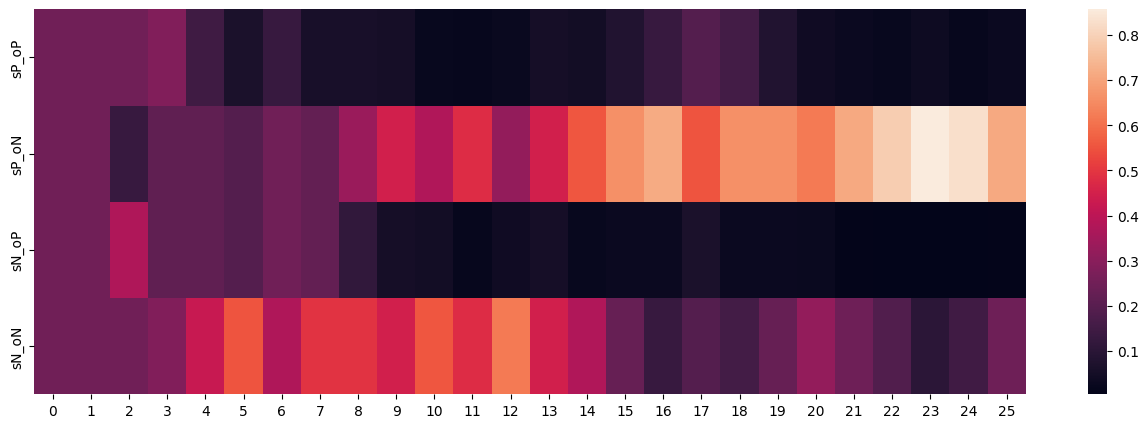

In [68]:
import seaborn as sns

labels = {
    0: "s_pos_o_zer",
    1: "s_neg_o_zer",
    2: "s_zer_o_pos",
    3: "s_zer_o_neg",
    4: "s_zer_o_zer",
}

n_block = 0
n_subject = 0

plt.figure(figsize=(16, 5))
sns.heatmap(samples["beliefs"][0][0][n_block, n_subject].T)
plt.yticks([0.5, 1.5, 2.5, 3.5], labels=agency_names)

exp_condition = samples["states"][-1][0][0]

print(labels[exp_condition[n_block, n_subject].item()])

In [69]:
exp_condition = samples["states"][-1][0][0]
last_beliefs_about_condition = samples["beliefs"][0][..., -1, :]

self_rating = (
    last_beliefs_about_condition[0, ..., 0]
    + last_beliefs_about_condition[0, ..., 1]
    - last_beliefs_about_condition[0, ..., 2]
    - last_beliefs_about_condition[0, ..., 3]
)
other_rating = (
    last_beliefs_about_condition[0, ..., 0]
    + last_beliefs_about_condition[0, ..., 2]
    - last_beliefs_about_condition[0, ..., 1]
    - last_beliefs_about_condition[0, ..., 3]
)

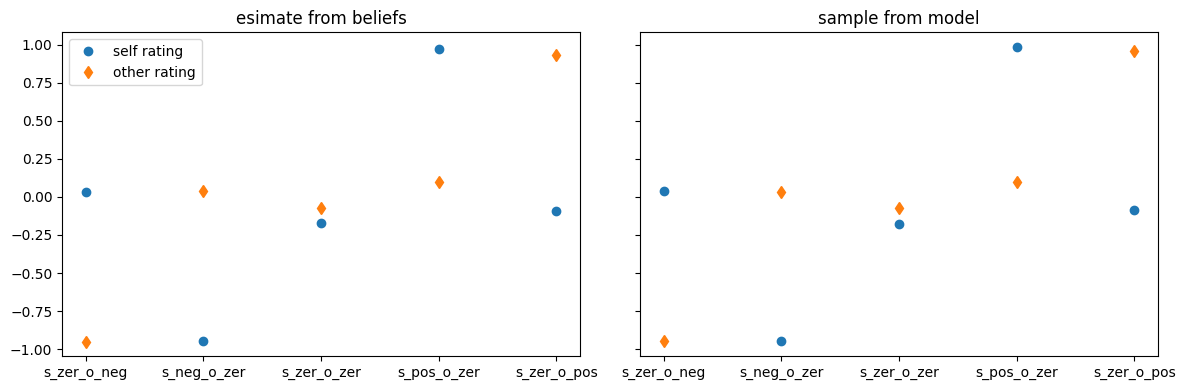

In [70]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharex=True, sharey=True)

smpl_other_rating = samples["aux_other"][0, ..., -1]
smpl_self_rating = samples["aux_self"][0, ..., -1]

x = []
y1 = []
y2 = []
smpl_y1 = []
smpl_y2 = []
for i in [3, 1, 4, 0, 2]:
    loc = exp_condition == i
    x.append(labels[i])
    y1.append(self_rating[loc].mean())
    y2.append(other_rating[loc].mean())

    smpl_y1.append(smpl_self_rating[loc].mean())
    smpl_y2.append(smpl_other_rating[loc].mean())

axes[0].plot(x, y1, "o", label="self rating")
axes[0].plot(x, y2, "d", label="other rating")

axes[1].plot(x, smpl_y1, "o", label="self rating")
axes[1].plot(x, smpl_y2, "d", label="other rating")

axes[0].set_title("esimate from beliefs")
axes[1].set_title("sample from model")

axes[0].legend()
fig.tight_layout()

### Parameter recovery with simulated behaviour

Here we will demonstrate that the model parameters are recoverable, 
if one simulates the behavior using the paramatric generative model 
of the active inference agents, and then inverts the model using the 
simulated responses. Bellow we illustrate that all of the 8 parameters 
are well recoverable, as the estimated means fall along the axis that 
follows true parameter values. 

{'seed': 101, 'enumerate': False, 'iter_steps': 1000, 'optim': None, 'optim_kwargs': {'learning_rate': 0.001}, 'elbo_kwargs': {'num_particles': 10, 'max_plate_nesting': 1}, 'svi_kwargs': {'progress_bar': True, 'stable_update': True}, 'sample_kwargs': {'num_samples': 100}}


100%|██████████| 1000/1000 [08:10<00:00,  2.04it/s, init loss: 55985.7148, avg. loss [951-1000]: 15447.9530]


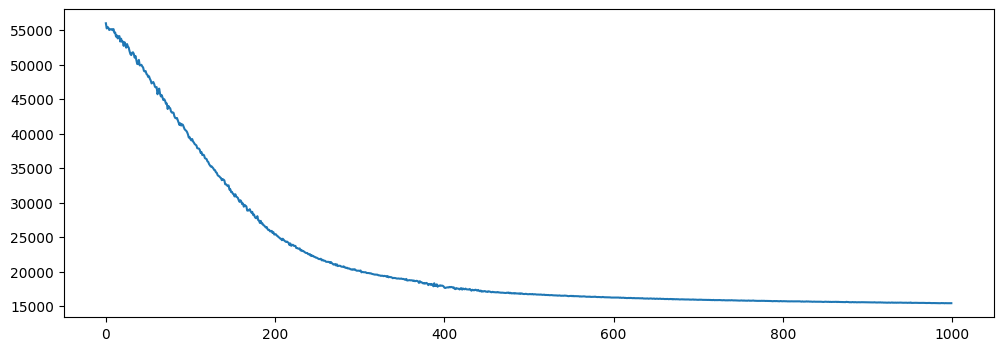

In [71]:
measurments = {
    "outcomes": [outcomes[0] for outcomes in samples["outcomes"]],
    "multiactions": samples["multiactions"][0],
    "multiaction_cat": samples["multiaction_cat"][0],
    "auxiliary_actions": [
        samples["aux_self"][0],
        samples["aux_other"][0],
    ],
}

model = NumpyroModel(prior, transform, likelihood, opts=opts_model)
posterior = NumpyroGuide(NormalPosterior(num_params, num_agents, backend="numpyro"))

# perform inference using stochastic variational inference
opts_svi = default_dict_numpyro_svi | {"iter_steps": 1000, "seed": 101}
print(opts_svi)

svi_samples, svi, results = run_svi(model, posterior, measurments, opts=opts_svi)
plt.figure(figsize=(12, 4))
plt.plot(results.losses)

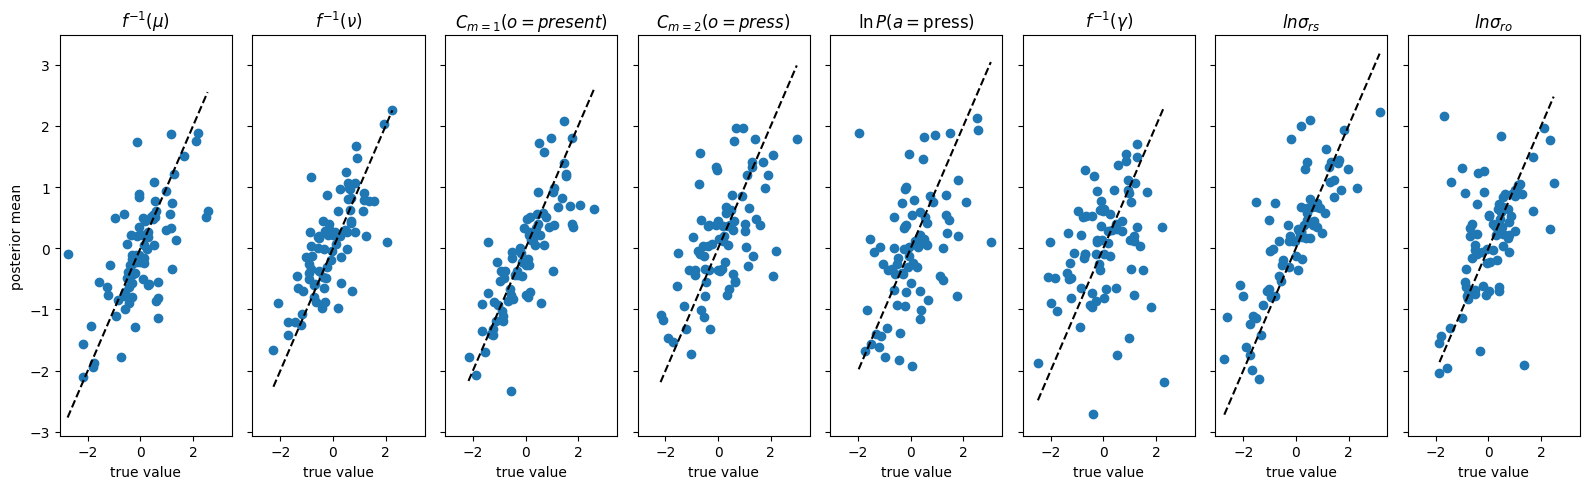

In [73]:
param_label = [
    r"$f^{-1}(\mu)$",
    r"$f^{-1}(\nu)$",
    r"$C_{m=1}(o=present)$",
    r"$C_{m=2}(o=press)$",
    r"$\ln P(a=\text{press})$",
    r"$f^{-1}(\gamma)$",
    r"$ln \sigma_{rs}$",
    r"$ln \sigma_{ro}$",
]
z = samples["z"][0]
fig, axes = plt.subplots(1, z.shape[-1], figsize=(16, 5), sharex=True, sharey=True)

for i in range(z.shape[-1]):
    axes[i].scatter(z[:, i], svi_samples["z"].mean(0)[:, i], label=i)
    axes[i].plot((z[:, i].min(), z[:, i].max()), (z[:, i].min(), z[:, i].max()), "k--")
    axes[i].set_xlabel("true value")
    axes[i].set_title(param_label[i])

axes[0].set_ylabel("posterior mean")
fig.tight_layout()

## Fitting behavioural data

In [80]:
import pandas as pd

exp_data = pd.read_csv("behavioural_data_agency.csv")

outcomes = [[], [], []]
multiactions = []
ratings = [[], []]
group = []
for pid in exp_data.PID.unique():
    df = exp_data.loc[exp_data.PID == pid].pivot(
        index=["block_num"],
        columns=["timesteps"],
        values=[
            "outcome",
            "action_self",
            "action_other",
            "rating_self",
            "rating_other",
        ],
    )
    group.append(exp_data.loc[exp_data.PID == pid].depgroup.unique().item())
    outcomes[0].append(jnp.array(df.outcome.values))
    outcomes[1].append(jnp.array(df.action_self.values))
    outcomes[2].append(jnp.array(df.action_other.values))

    ratings[0].append(jnp.array(df.rating_self.values))

    ratings[1].append(jnp.array(df.rating_other.values))

    for o in outcomes:
        if jnp.any(jnp.isnan(o[-1])):
            print(pid)

    multiactions.append(outcomes[1][-1])


outcomes = [jnp.pad(jnp.stack(o, 1), [(0, 0), (0, 0), (1, 0)]) for o in outcomes]
multiactions = jnp.pad(
    jnp.stack(multiactions, 1)[..., None], [(0, 0), (0, 0), (0, 0), (1, 1)]
)

ratings = [jnp.stack(r, 1) / 100 for r in ratings]
exp_measurments = {
    "outcomes": outcomes,
    "multiactions": multiactions,
    "auxiliary_actions": ratings,
}

opts_task = {
    "num_blocks": multiactions.shape[0],
    "num_trials": multiactions.shape[-2],
    "num_agents": multiactions.shape[1],
}

opts_model = {"prior": {}, "transform": {}, "likelihood": opts_task}

In [81]:
def plot_results(samples):
    param_label = [
        r"$f^{-1}(\mu)$",
        r"$f^{-1}(\nu)$",
        r"$C_{m=1}(o=present)$",
        r"$C_{m=2}(o=press)$",
        r"$\ln P(a=\text{press})$",
        r"$f^{-1}(\gamma)$",
        r"$ln \sigma_{rs}$",
        r"$ln \sigma_{ro}$",
    ]

    fig, axes = plt.subplots(1, num_params, figsize=(16, 5), sharex=True, sharey=True)
    grp = jnp.array([0 if g == "nondep" else 1 for g in group])
    dep = grp == 1
    for i in range(num_params):
        sns.swarmplot(samples["z"].mean(0)[~dep, i], ax=axes[i], label="nondep")
        sns.swarmplot(samples["z"].mean(0)[dep, i], ax=axes[i], label="dep")
        axes[i].set_title(param_label[i])

    axes[0].legend(title="group")
    axes[0].set_ylabel("value")
    fig.tight_layout()

First we will fit the data using a simple flat prior over model parameters, where each uncostrained values of each parameter (before transform) are sampled from a standard noraml distribution. 

100%|██████████| 2000/2000 [12:58<00:00,  2.57it/s, init loss: 99116.6875, avg. loss [1901-2000]: 22216.0436]


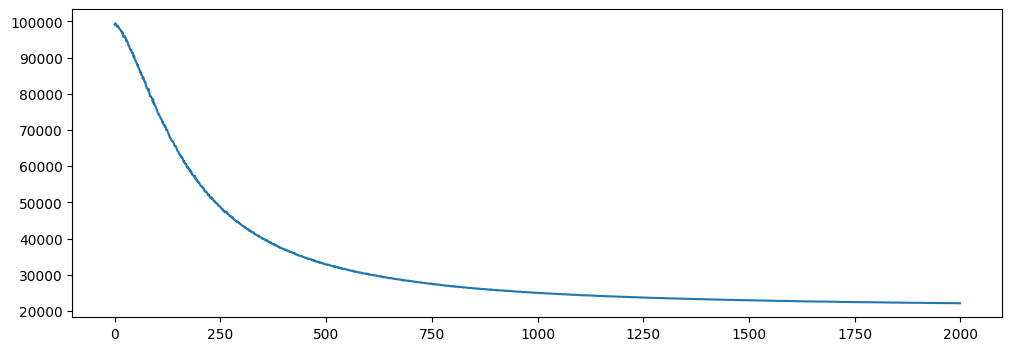

In [82]:
prior = Normal(num_params, num_agents, backend="numpyro")
model = NumpyroModel(prior, transform, likelihood, opts=opts_model)

posterior = NumpyroGuide(NormalPosterior(num_params, num_agents, backend="numpyro"))

# perform inference using stochastic variational inference
opts_svi = default_dict_numpyro_svi | {"iter_steps": 2000, "seed": 1123567}
svi_samples1, svi1, results1 = run_svi(model, posterior, exp_measurments, opts=opts_svi)

plt.figure(figsize=(12, 4))
plt.plot(results1.losses)

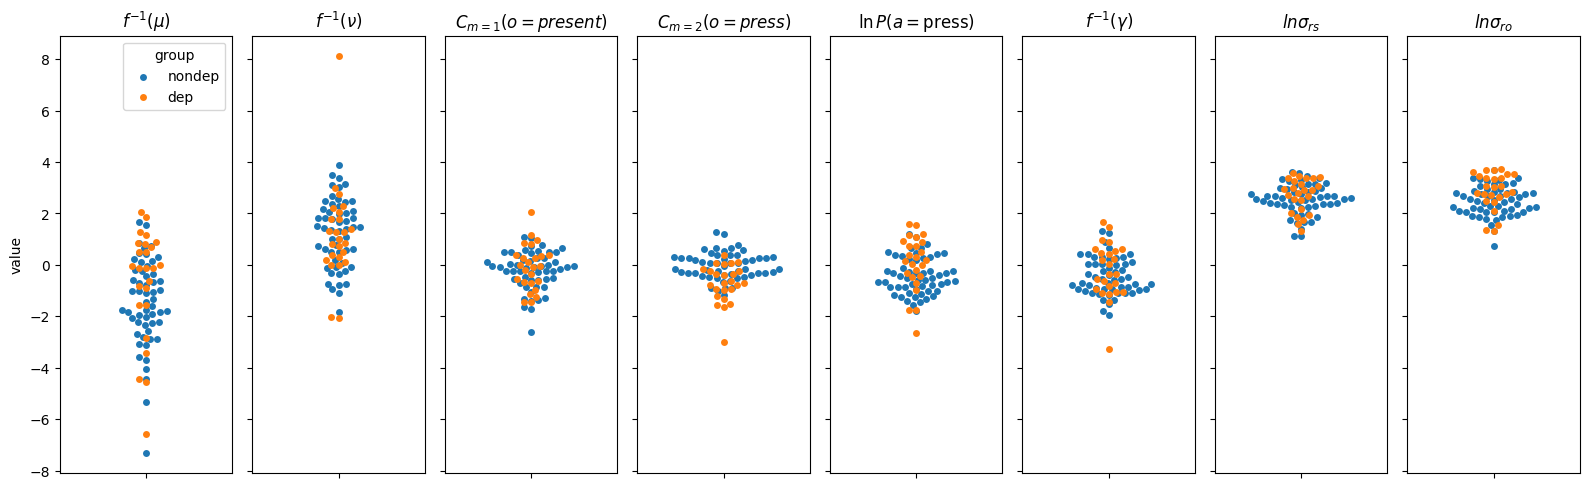

In [83]:
plot_results(svi_samples1)

As a second example we will fit the data using the NormalGamma prior over unconstrained parameter values, where one infers prior uncertainty on a group level for each parameter. 

100%|██████████| 2000/2000 [12:41<00:00,  2.63it/s, init loss: 70882.1797, avg. loss [1901-2000]: 20596.2173]


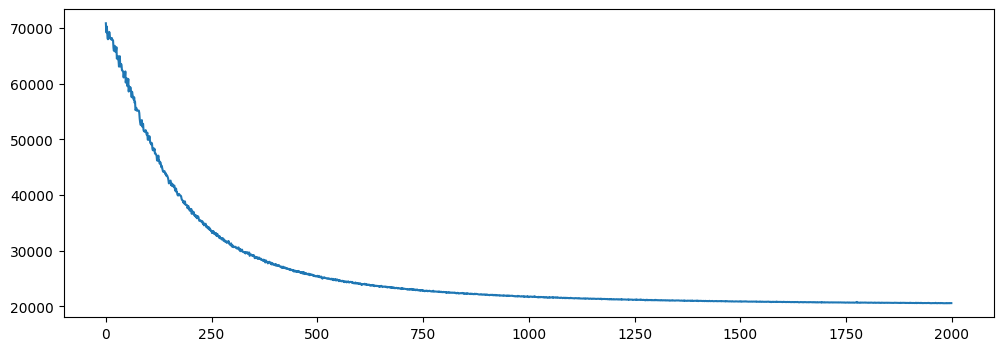

In [84]:
prior = NormalGamma(num_params, num_agents, backend="numpyro")
model = NumpyroModel(prior, transform, likelihood, opts=opts_model)

posterior = NumpyroGuide(
    NormalGammaPosterior(num_params, num_agents, backend="numpyro")
)

# perform inference using stochastic variational inference
opts_svi = default_dict_numpyro_svi | {"iter_steps": 2000, "seed": 197823476}
svi_samples2, svi2, results2 = run_svi(model, posterior, exp_measurments, opts=opts_svi)

plt.figure(figsize=(12, 4))
plt.plot(results2.losses)

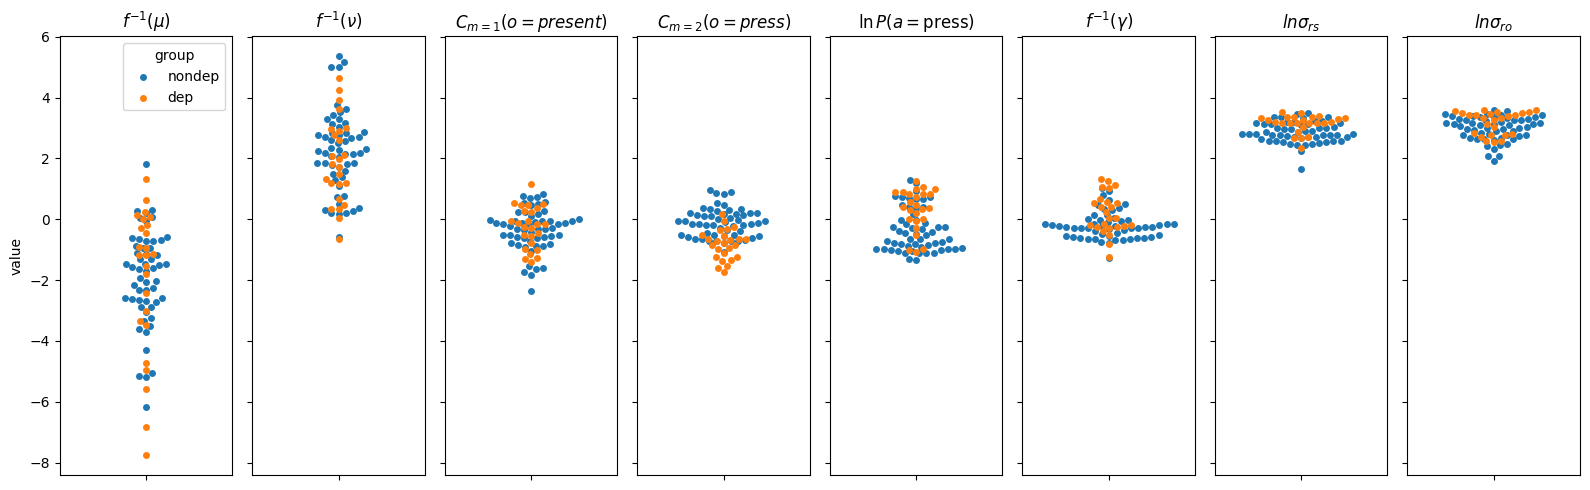

In [85]:
plot_results(svi_samples2)

As a final exmaple we will fit the data using the RegularisedHorseshoe prior over unconstrained parameter values. This prior puts a lots of a priory wait on group mean, as an only relevant parameter, hence it has a strong pulling effect between participants, which can help to estimate corretly group level mean, when the experimental data do not contain sufficient information about specific parameter value on a single subject level.

100%|██████████| 2000/2000 [12:44<00:00,  2.62it/s, init loss: 71484.2031, avg. loss [1901-2000]: 20481.5930]


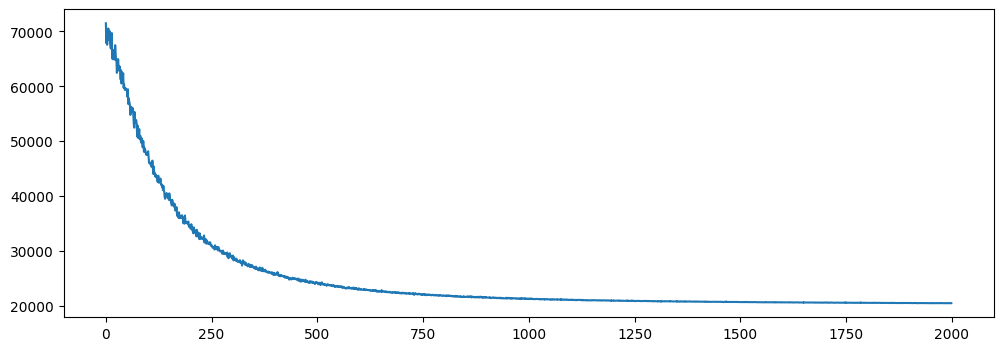

In [86]:
prior = RegularisedHorseshoe(num_params, num_agents, backend="numpyro")
model = NumpyroModel(prior, transform, likelihood, opts=opts_model)

posterior = NumpyroGuide(
    RegularisedHorseshoePosterior(num_params, num_agents, backend="numpyro")
)

# perform inference using stochastic variational inference
opts_svi = default_dict_numpyro_svi | {"iter_steps": 2000, "seed": 623342}
svi_samples3, svi3, results3 = run_svi(model, posterior, exp_measurments, opts=opts_svi)

plt.figure(figsize=(12, 4))
plt.plot(results3.losses)

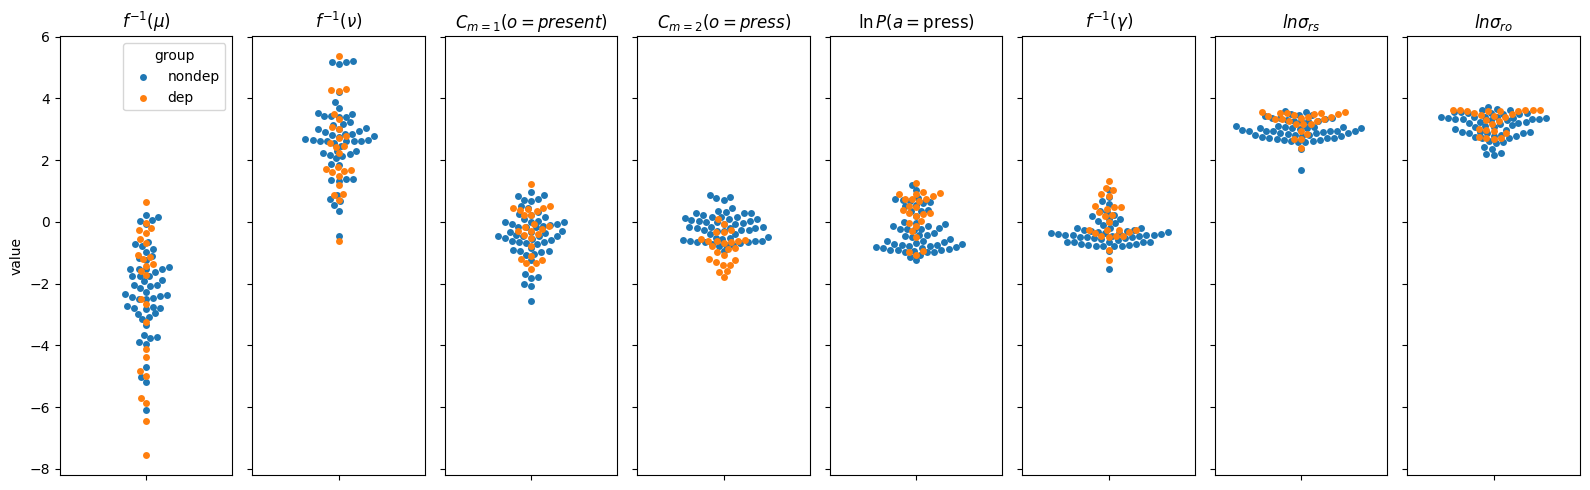

In [87]:
plot_results(svi_samples3)